In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")

In [4]:
print("Missing values in train:")
print(train_df.isnull().sum())

print("\nMissing values in test:")
print(test_df.isnull().sum())

Missing values in train:
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

Missing values in test:
id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64


In [5]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
test_df['winddirection'] = imputer.fit_transform(test_df[['winddirection']])

In [ ]:
# Create a new column called prev_day_rain
train_df['temp_humidity_interaction'] = train_df['temparature'] * train_df['humidity']
train_df['cloud_sun_ratio'] = train_df['cloud'] / (train_df['sunshine'] + 1)
train_df.fillna(0, inplace=True)

In [ ]:
test_df['temp_humidity_interaction'] = test_df['temparature'] * test_df['humidity']
test_df['cloud_sun_ratio'] = test_df['cloud'] / (test_df['sunshine'] + 1)

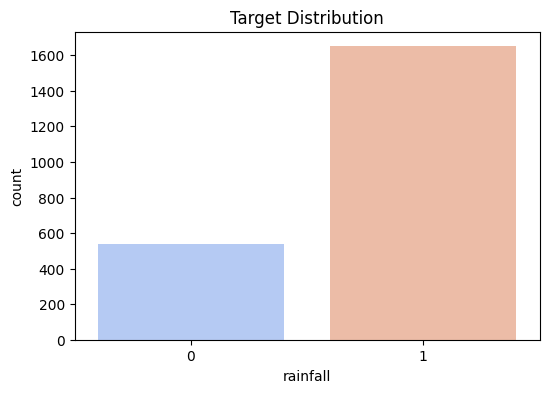

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.countplot(x='rainfall', data=train_df, palette='coolwarm')
plt.title("Target Distribution")
plt.show()

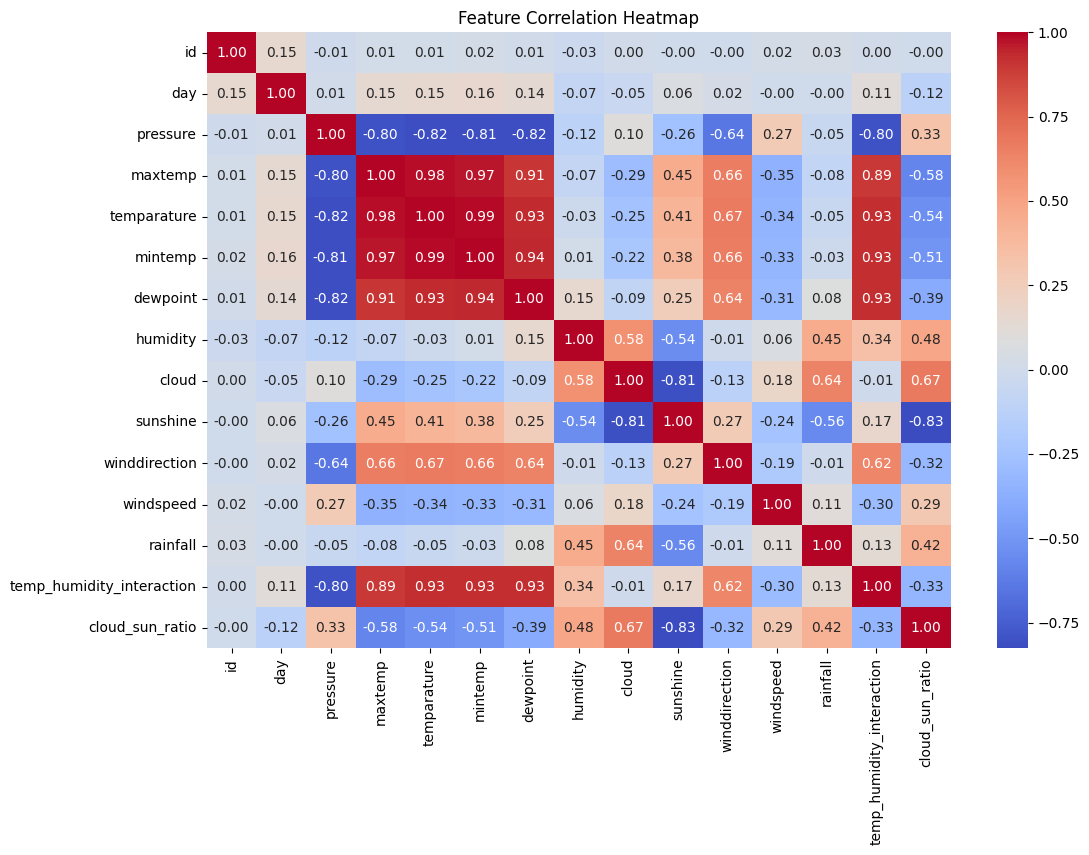

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

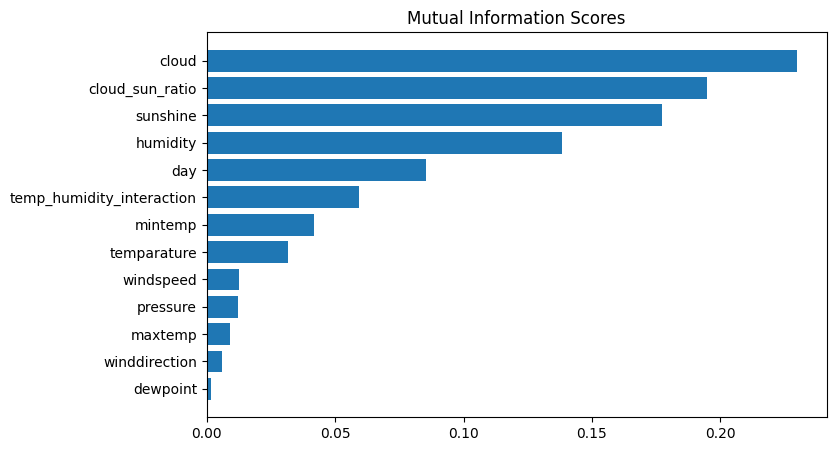

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

X = train_df.drop(columns=['rainfall', 'id']) #
y = train_df['rainfall']
mi_scores = make_mi_scores(X, y)
mi_scores[::3] 

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
X = train_df.drop(columns=['rainfall', 'id']) 
y = train_df['rainfall']
X_test = test_df.drop(columns=['id'])

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [15]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
day,-0.055785,0.035017,0.944219,-0.215874,0.091673,-0.158086,-0.101654,-0.115719,0.004754,0.012161,0.010162,0.009036,0.006050
pressure,0.324625,0.154416,0.126929,-0.113255,-0.058556,-0.069411,0.467223,0.762760,-0.173499,-0.053345,0.017988,-0.008251,-0.012253
maxtemp,-0.377174,-0.024154,0.030930,0.023136,-0.019192,0.189595,0.043991,0.143768,-0.057592,0.344500,0.725758,-0.374631,0.087606
temparature,-0.378826,-0.058926,0.042544,0.027824,-0.031258,0.185002,0.019811,0.161655,-0.083675,0.202609,-0.105863,0.363367,-0.772925
mintemp,-0.374770,-0.081865,0.055294,0.029593,-0.038160,0.181500,0.002518,0.178666,-0.087600,0.067005,-0.641106,-0.588436,0.114671
dewpoint,-0.355820,-0.170998,0.040550,0.008082,-0.065796,0.142420,-0.003155,0.119651,-0.026820,-0.875634,0.181540,0.050267,0.023785
humidity,0.025320,-0.499670,-0.049143,-0.106081,-0.542506,-0.590719,0.008555,-0.016073,0.032327,0.019006,0.054433,-0.211037,-0.208618
cloud,0.133460,-0.498573,0.053014,-0.052947,0.214352,0.237883,0.600619,-0.379511,-0.346570,0.022619,-0.006470,-0.005340,-0.000276
sunshine,-0.200557,0.463549,-0.060096,0.061642,-0.210779,-0.276078,0.049799,-0.232754,-0.744968,-0.046808,-0.002405,0.035159,0.042146
winddirection,-0.278878,-0.079555,-0.093864,0.248565,0.675283,-0.596397,0.128149,0.118298,0.055188,-0.008063,-0.003122,-0.005797,-0.005888


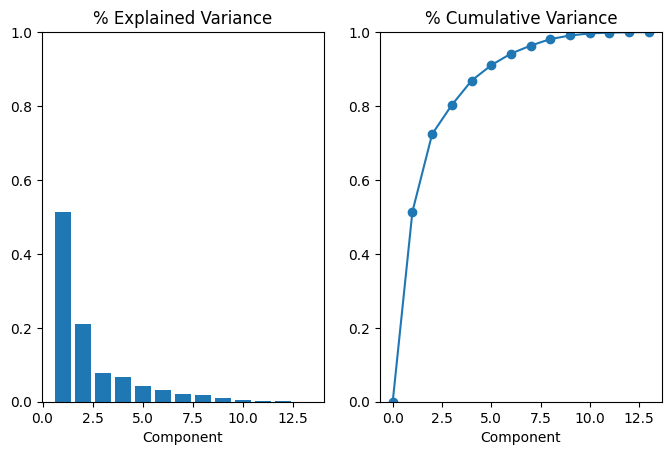

In [16]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs
    
plot_variance(pca);

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=36, stratify=y)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(eval_metric='logloss'),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc'
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Initialize lists to store metrics
roc_scores = []
accuracy_scores = []
conf_matrices = []

# Setup stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in cv.split(X_scaled, y):
    # Split data
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Train model with best parameters
    model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1]
    
    # Calculate metrics
    roc_scores.append(roc_auc_score(y_val, y_proba))
    accuracy_scores.append(accuracy_score(y_val, y_pred))
    conf_matrices.append(confusion_matrix(y_val, y_pred))

# Print average results
print(f"Average ROC AUC: {np.mean(roc_scores):.4f} (±{np.std(roc_scores):.4f})")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} (±{np.std(accuracy_scores):.4f})")

# Confusion matrix aggregation
mean_conf_matrix = np.mean(conf_matrices, axis=0)
print("\nAverage Confusion Matrix:")
print(mean_conf_matrix.round().astype(int))


Average ROC AUC: 0.8893 (±0.0251)
Average Accuracy: 0.8667 (±0.0208)

Average Confusion Matrix:
[[ 70  38]
 [ 20 310]]


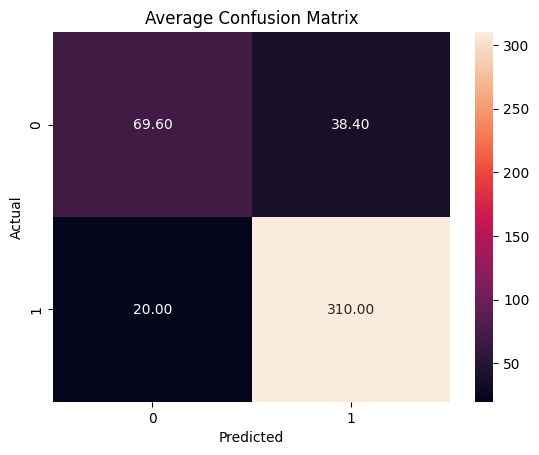

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(mean_conf_matrix, annot=True, fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Average Confusion Matrix')
plt.show()

In [22]:
# Combine train + validation data
X_full_train = np.concatenate([X_train, X_val])
y_full_train = np.concatenate([y_train, y_val])

# Train final model on all data with optimal iterations
production_model = xgb.XGBClassifier(**best_params)
production_model.fit(X_full_train, y_full_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
test_predictions = production_model.predict_proba(X_test_scaled)[:, 1]

In [26]:
submission = pd.DataFrame({'id': test_df['id'], 'rainfall': test_predictions})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
